# Closed Orbit perturbation

Let's consider a sudden kick $\Delta P_x = \Delta p_x/p_0$ acting at a position $s_0$ of a beamline. This will change the closed orbit, which is assumed to be initially following the reference trajectory ($x(s) = 0$). To satisfy the periodic condition of the closed orbit, one can show (A. Wolski, Chap. 6) that the closed-orbit-particle must have a non-zero action:
$$\begin{aligned}J_{x} &= \frac{\beta_{x}(s_0)\Delta P_x^2}{8\sin^2(\pi Q_x)}\\
\phi_x(s_0) &= -\pi Q_x\end{aligned}$$

And hence, with regard to the original reference trajectory, the closed orbit now follows:
$$x_\text{co}(s) = \sqrt{2\beta_x(s)J_x}\cos(|\mu_x(s_0,s)|-\pi Q_x) = \sqrt{\frac{\beta_x(s)\beta_x(s_0)}{4\sin^2(\pi Q_x)}} \Delta P_x \cos(|\mu_x(s_0,s)|-\pi Q_x)$$

In the case of a double wire configuration, the only dipolar kick comes from a misalignment of the 5th axis. One can show that:
$$\Delta P_x = -K_{N_0} = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2\cos(\phi_w)}{r_w}\right] = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2 x_w}{x_w^2 + y_w^2}\right]$$

And if the wires are installed in the horizontal plane:
$$\Delta P_y = K_{S_0} = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2\sin(\phi_w)}{r_w}\right] = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2 y_w}{x_w^2 + y_w^2}\right]$$

Finally, to facilitate the analysis, one can look at $x_\text{co}(s)/\sqrt{\beta_x(s)}$


### Python implementation

In [2]:
import numpy as np
import Backend.Constants as cst

#=========================================
# Fitting function
#=========================================
def get_x_co(mux_s,betx_s,I,xw,yw,Qx,mu0 = 0,E = 450e9,L=1):
    # Confirming that mu and bet were given as vectors
    assert(np.shape(mux_s)==np.shape(betx_s))
    
    # Constants calculations
    Brho   = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    kick_0 = cst.mu0*(I*L)/(Brho*2*np.pi)
    kick   = kick_0*(2*xw/(xw**2+yw**2))
    
    # Finding beta at location of kick
    bet0 = betx_s[np.argmin(np.abs(mux_s-mu0))] 
    Amp  = np.sqrt(betx_s*bet0/(4*np.sin(np.pi*Qx)**2)) * kick
    
    return Amp*np.cos(2*np.pi*(np.abs(mux_s-mu0)) - np.pi*Qx)


def get_y_co(muy_s,bety_s,I,xw,yw,Qy,mu0 = 0,E = 450e9,L=1):
    # Confirming that mu and bet were given as vectors
    assert(np.shape(muy_s)==np.shape(bety_s))
    
    # Constants calculations
    Brho   = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    kick_0 = cst.mu0*(I*L)/(Brho*2*np.pi)
    kick   = kick_0*(2*yw/(xw**2+yw**2))
    
    # Finding beta at location of kick
    bet0 = bety_s[np.argmin(np.abs(muy_s-mu0))] 
    Amp  = np.sqrt(bety_s*bet0/(4*np.sin(np.pi*Qy)**2)) * kick
    
    return Amp*np.cos(2*np.pi*(np.abs(muy_s-mu0)) - np.pi*Qy)
#==========================================



## Reference exemple

In [ ]:
#%matplotlib widget

In [48]:
%matplotlib inline

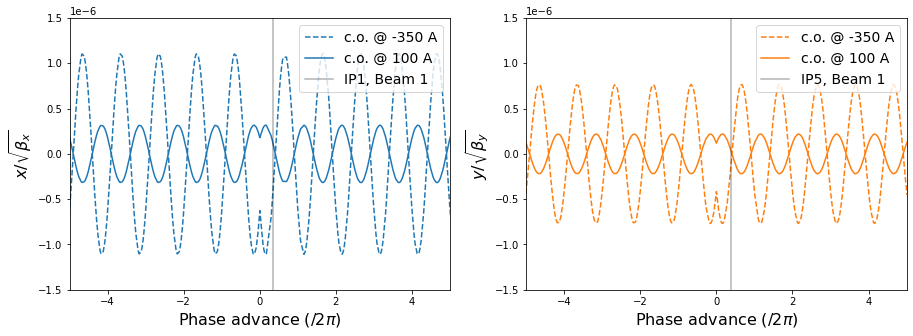

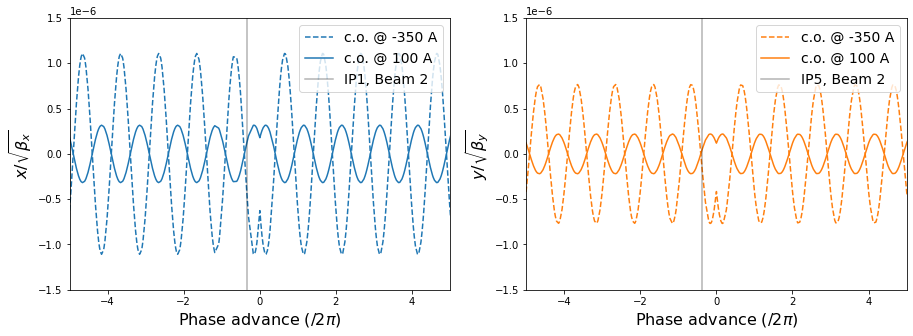

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx
import twissExtractor



# Importing twiss
#=====================

twiss = twissExtractor.fromOptics('opticsfile.1')


# Setting reasonable parameters
gap    = 15e-3
offset = 0.5e-3

# Looping for both beams and both IPs
for beam in ['B1','B2']:
    
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    
    
    for IP,ax in zip(['ip1','ip5'],axes):
        for I_w,ls in zip([-350,100],['--','-']):
            _wires = [name for name in twiss[beam].index if ('bbcw' in name)&((f'{IP[-1]}.u' in name)|(f'{IP[-1]}.d' in name))]

            if IP.lower() == 'ip1':
                CO    = get_x_co(mux_s = twiss[beam]['mux'],
                                 betx_s= twiss[beam]['betx'],
                                 I     = I_w,
                                 xw    = offset,
                                 yw    = gap+3e-3,
                                 Qx    = twiss[beam]['mux'][-1],
                                 mu0   = twiss[beam].loc[_wires,'mux'].mean(),
                                 E = 450e9,L=1)
                mu_CO   = twiss[beam]['mux'].to_numpy() - twiss[beam].loc[_wires,'mux'].mean()
                norm_CO = CO/np.sqrt(twiss[beam]['betx'])
                IP_loc  = twiss[beam].loc[IP.lower(),'mux'] - twiss[beam].loc[_wires,'mux'].mean()

                color='C0'
                label=r'$x/\sqrt{\beta_x}$'

            if IP.lower() == 'ip5':
                CO    = get_y_co(muy_s = twiss[beam]['muy'],
                                 bety_s= twiss[beam]['bety'],
                                 I     = I_w,
                                 xw    = gap+3e-3,
                                 yw    = offset,
                                 Qy    = twiss[beam]['muy'][-1],
                                 mu0   = twiss[beam].loc[_wires,'muy'].mean(),
                                 E = 450e9,L=1)
                mu_CO   = twiss[beam]['muy'].to_numpy() - twiss[beam].loc[_wires,'muy'].mean()
                norm_CO = CO/np.sqrt(twiss[beam]['bety'])
                IP_loc  = twiss[beam].loc[IP.lower(),'muy'] - twiss[beam].loc[_wires,'muy'].mean()

                color='C1'
                label=r'$y/\sqrt{\beta_y}$'

            # Plotting
            plt.sca(ax)
            plt.plot(mu_CO,norm_CO,ls,color=color,label=f'c.o. @ {I_w} A')
            

        plt.axvline(IP_loc,color='k',alpha=0.3,label=IP.upper() + f', Beam {beam[-1]}')
        plt.ylabel(label,fontsize=16)
        plt.xlabel(r'Phase advance ($/2\pi$)',fontsize=16)
        plt.legend(loc='upper right',fontsize=14)
        plt.xlim([-5,5])
        plt.ylim([-1.5e-6,1.5e-6])


In [45]:

for i in range(30):

    mu_vec   = np.linspace(0.5,twiss[beam]['mux'][-1],i+100)
    cos_test = 5*np.cos(2*np.pi*mu_vec)
    signal = cos_test+np.random.normal(0,0.05*5,len(cos_test))

    #plt.figure()
    #plt.plot(mu_vec,signal)
    #plt.xlim([20,30])

    amp1 = (np.max(signal)-np.min(signal))/2
    amp2 = np.std(signal)*np.sqrt(2)
    print(40*'-')
    print(f'Max-min yields : {amp1:.15f}, Err: {np.abs(amp1-5)/5*100:.3}%')
    print(f'RMS yields     : {amp2:.15f}, Err: {np.abs(amp2-5)/5*100:.3}%')

----------------------------------------
Max-min yields : 5.411674710707629, Err: 8.23%
RMS yields     : 5.037502751112660, Err: 0.75%
----------------------------------------
Max-min yields : 5.287096035151783, Err: 5.74%
RMS yields     : 5.038909665061195, Err: 0.778%
----------------------------------------
Max-min yields : 5.297131934947902, Err: 5.94%
RMS yields     : 5.057963111025694, Err: 1.16%
----------------------------------------
Max-min yields : 5.330243248994318, Err: 6.6%
RMS yields     : 5.028189206263554, Err: 0.564%
----------------------------------------
Max-min yields : 5.019283576168103, Err: 0.386%
RMS yields     : 4.966858767591703, Err: 0.663%
----------------------------------------
Max-min yields : 5.444088089160992, Err: 8.88%
RMS yields     : 5.023723049401243, Err: 0.474%
----------------------------------------
Max-min yields : 5.570027999606721, Err: 11.4%
RMS yields     : 5.014490959780852, Err: 0.29%
----------------------------------------
Max-min yi

In [19]:
import ipywidgets as widgets
from ipywidgets import *


def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

top_left_button = create_expanded_button("Top left", 'info')
top_right_button = create_expanded_button("Top right", 'success')
bottom_left_button = create_expanded_button("Bottom left", 'danger')
bottom_right_button = create_expanded_button("Bottom right", 'warning')

top_left_text = IntText(description='Top left', layout=Layout(width='auto', height='auto'))
top_right_text = IntText(description='Top right', layout=Layout(width='auto', height='auto'))
bottom_left_slider = IntSlider(description='Bottom left', layout=Layout(width='auto', height='auto'))
bottom_right_slider = IntSlider(description='Bottom right',orientation='vertical', layout=Layout(width='auto', height='auto'))

In [20]:
app = TwoByTwoLayout(top_left=top_left_text, top_right=top_right_text,
                     bottom_left=bottom_left_slider, bottom_right=bottom_right_slider)

link_left = jslink((app.top_left, 'value'), (app.bottom_left, 'value'))
link_right = jslink((app.top_right, 'value'), (app.bottom_right, 'value'))
app.bottom_right.value = 30
app.top_left.value = 25
app

TwoByTwoLayout(children=(IntText(value=25, description='Top left', layout=Layout(grid_area='top-left', height=…

In [29]:
%matplotlib inline

AttributeError: 'Output' object has no attribute 'append'

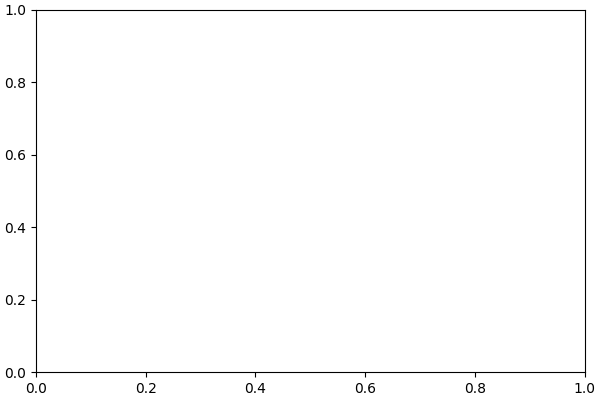

In [42]:

%matplotlib widget
output = widgets.Output();
 
# create some x data
x = np.linspace(0, 2 * np.pi, 100)
 
# default line color
initial_color = '#FF00DD'
 
#with output:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
output.append(fig) 
# move the toolbar to the bottom
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)    
line, = ax.plot(x, np.sin(x), initial_color)

widgets.HBox([output, output])

In [48]:
%matplotlib widget

from ipywidgets import Button, Output, VBox


out = Output()
out.layout.border = "2px solid green"

with out:
    fig, ax = plt.subplots(1, 1)
    display(fig.canvas)

VBox([out, Button(description="click")])

In [292]:
%matplotlib widget
from matplotlib import pyplot as plt
import ipywidgets as widgets
import time

class myApp():
    def __init__(self,):
    
        # Making sure ioff() is on
        plt.ioff()
        
        
        #
        if False:
            showBorder = 'solid'
        else:
            showBorder = ''
        
        self.height = 400
        self.width = 600
        px = 1/plt.rcParams['figure.dpi']
        
        # BEAM
        #======================
        self.panel_beam = widgets.Output(layout=widgets.Layout(display='flex',border=showBorder,width=f'{3/5*self.width}px', height=f'{3/5*self.height}px'))
        with self.panel_beam:
            self.fig_beam, self.ax_beam = plt.subplots(constrained_layout=True, figsize=(0.9*3/5*self.width*px,0.9*3/5*self.height*px))
            self.fig_beam.canvas.resizable       = False
            self.fig_beam.canvas.footer_visible  = False
            self.fig_beam.canvas.header_visible  = False
            self.fig_beam.canvas.toolbar_visible = False
            
            self.coll_lines = {}
            self.coll_lines['t'], = self.ax_beam.plot([0] ,[1],'o',color='C0')
            self.coll_lines['b'], = self.ax_beam.plot([0] ,[-1],'o',color='C0')
            self.coll_lines['l'], = self.ax_beam.plot([-1],[0],'o',color='C0')
            self.coll_lines['r'], = self.ax_beam.plot([1] ,[0],'o',color='C0')
            
            self.ax_beam.axhline(0,color='k',alpha=0.5,zorder=-1)
            self.ax_beam.axvline(0,color='k',alpha=0.5,zorder=-1)
            self.ax_beam.set_aspect('equal')#'box'
            self.ax_beam.axis([-1.5, 1.5, -1.5, 1.5])
            
            
            display(self.fig_beam.canvas)
        #======================
        #======================
        self.panel_CO = widgets.Output(layout=widgets.Layout(display='flex',border=showBorder,width=f'{self.width}px', height=f'{1.1*self.height}px'))
        with self.panel_CO:
            self.fig_CO, self.ax_CO = plt.subplots(constrained_layout=True, figsize=(0.9*self.width*px,0.9*1.1*self.height*px))
            self.fig_CO.canvas.resizable       = False
            self.fig_CO.canvas.footer_visible  = False
            self.fig_CO.canvas.header_visible  = False
            self.fig_CO.canvas.toolbar_visible = False
            
            display(self.fig_CO.canvas)
        #======================
        
        # Collimators
        
        self.coll_slider = {}
        slider_opt = {'value':0,'min':-1,'max':1}
        self.coll_slider['t']= widgets.FloatSlider(description='',**slider_opt,orientation='horizontal',layout=widgets.Layout(display='flex',border=showBorder,width=f'{3/5*self.width}px', height=f'{1/5*self.height}px'),continuous_update=False)
        self.coll_slider['b']= widgets.FloatSlider(description='',**slider_opt,orientation='horizontal',layout=widgets.Layout(display='flex',border=showBorder,width=f'{3/5*self.width}px', height=f'{1/5*self.height}px'),continuous_update=False)
        self.coll_slider['l']= widgets.FloatSlider(description='',**slider_opt,orientation='vertical'  ,layout=widgets.Layout(display='flex',border=showBorder,width=f'{1/5*self.width}px', height=f'{3/5*self.height}px'),continuous_update=False)
        self.coll_slider['r']= widgets.FloatSlider(description='',**slider_opt,orientation='vertical'  ,layout=widgets.Layout(display='flex',border=showBorder,width=f'{1/5*self.width}px', height=f'{3/5*self.height}px'),continuous_update=False)

        for coll in ['l','r','b','t']:
            self.coll_slider[coll].observe(self.update_beam_plot,'value')
            
        
        # Chosen IP
        self.IP = 'ip1'
        self.IP_buttons = {}
        self.IP_buttons['ip1'] = widgets.Button(value='ip1',description='IP1', button_style='info'   , layout=widgets.Layout(width=f'{1/5*self.width}px', height=f'{1/10*self.height}px'),continuous_update=False)
        self.IP_buttons['ip5'] = widgets.Button(value='ip5',description='IP5', button_style='warning',layout=widgets.Layout(width=f'{1/5*self.width}px', height=f'{1/10*self.height}px'),continuous_update=False)

        for IP in ['ip1','ip5']:
            self.IP_buttons[IP].on_click(self.on_IP_click)
        
        #initialize:
        self.coll_I={}
        self.on_IP_click(self.IP_buttons['ip1'])
        
        self.grid = widgets.GridspecLayout(5, 4, height=f'{1.5*self.height}px',width=f'{2*1.1*self.width}px')
        
        self.grid[1,1] = self.panel_beam
        self.grid[:,3] = self.panel_CO
        self.grid[0,1] = self.coll_slider['t']
        self.grid[1,0] = self.coll_slider['l']
        self.grid[1,2] = self.coll_slider['r']
        self.grid[2,1] = self.coll_slider['b']
        
        self.grid[0,0] = self.IP_buttons['ip1']
        self.grid[0,2] = self.IP_buttons['ip5']
        
        
        # RESET BUTTON
        self.reset_button = widgets.Button(value='reset',description='RESET', button_style='danger',layout=widgets.Layout(width=f'{1/5*self.width}px', height=f'{1/10*self.height}px'),continuous_update=False)
        self.reset_button.on_click(self.on_reset_click)
        self.grid[2,0] = self.reset_button
    
    
    def on_reset_click(self,b):
        time.sleep(0.5)
        for coll in ['l','r','b','t']:
            self.coll_slider[coll].value=0
        time.sleep(0.5)
            
            
    
    def on_IP_click(self,b):
        self.IP = str(b.description).lower()
        if self.IP == 'ip1':
            for coll,value in zip(['l','r','b','t'],[0,0,1,1]):
                self.coll_I[coll] = value
        if self.IP == 'ip5':
            for coll,value in zip(['l','r','b','t'],[1,1,0,0]):
                self.coll_I[coll] = value
        
        self.update_beam_plot('')
        
    def update_beam_plot(self,_): 
        for coll in ['l','r','b','t']:
            line,value = self.coll_lines[coll],self.coll_slider[coll].value
            if   self.coll_slider[coll].orientation == 'horizontal':
                line.set_xdata(value)
                line.set_alpha(self.coll_I[coll])
                
            elif self.coll_slider[coll].orientation == 'vertical':
                line.set_ydata(value)
                line.set_alpha(self.coll_I[coll])
        
        self.fig_beam.canvas.draw()
    
    def show(self,):
        display(self.grid)
        
test = myApp()
test.show()


GridspecLayout(children=(Output(layout=Layout(border='', display='flex', grid_area='widget001', height='240.0p…

In [220]:
for coll in ['l','r','b','t']:
    print(test.coll_slider[coll].value)

0.0
0.0
0.0
0.0


In [221]:
list(test.ax_beam.lines)

In [206]:
test.grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001', height='360.0px', width='600.0px'), outpu…

'ip1'

Sines(children=(VBox(children=(IntSlider(value=1, description='freq', max=10), ColorPicker(value='#FF00DD', de…

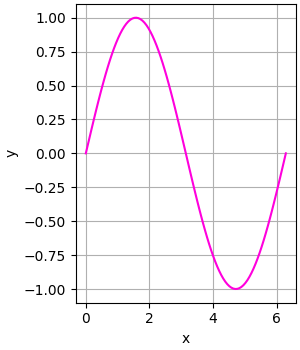

In [46]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
    
class Sines(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        output = widgets.Output()
 
        self.x = np.linspace(0, 2 * np.pi, 100)
        initial_color = '#FF00DD'
 
        #with output:
        self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(3, 3.5))
        self.line, = self.ax.plot(self.x, np.sin(self.x), initial_color)
         
        self.fig.canvas.toolbar_position = 'bottom'
        self.ax.grid(True)
 
        # define widgets
        int_slider = widgets.IntSlider(
            value=1, 
            min=0, 
            max=10, 
            step=1, 
            description='freq'
        )
        color_picker = widgets.ColorPicker(
            value=initial_color, 
            description='pick a color'
        )
        text_xlabel = widgets.Text(
            value='', 
            description='xlabel', 
            continuous_update=False
        )
        text_ylabel = widgets.Text(
            value='', 
            description='ylabel', 
            continuous_update=False
        )
 
        controls = widgets.VBox([
            int_slider, 
            color_picker, 
            text_xlabel, 
            text_ylabel
        ])
        controls.layout = make_box_layout()
         
        out_box = widgets.Box([output])
        output.layout = make_box_layout()
 
        # observe stuff
        int_slider.observe(self.update, 'value')
        color_picker.observe(self.line_color, 'value')
        text_xlabel.observe(self.update_xlabel, 'value')
        text_ylabel.observe(self.update_ylabel, 'value')
         
        text_xlabel.value = 'x'
        text_ylabel.value = 'y'
         
 
        # add to children
        self.children = [controls]
     
    def update(self, change):
        """Draw line in plot"""
        self.line.set_ydata(np.sin(change.new * self.x))
        self.fig.canvas.draw()
 
    def line_color(self, change):
        self.line.set_color(change.new)
 
    def update_xlabel(self, change):
        self.ax.set_xlabel(change.new)
 
    def update_ylabel(self, change):
        self.ax.set_ylabel(change.new)
         
         
Sines()